In [ ]:
import copy
import torch

import deepinv
from deepinv.physics import GaussianNoise, Inpainting
from deepinv.utils import plot, plot_curves
from deepinv.optim import L2, optim_builder
from deepinv.optim.optim_iterators import PGDIteration

# multilevel imports
from multilevel.info_transfer import BlackmannHarris
from multilevel.iterator import MultiLevelIteration, MultiLevelParams
from multilevel.prior import TVPrior

## 1- Download an image

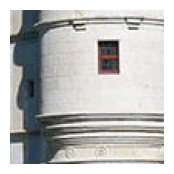

In [2]:
device = deepinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = "https://culturezvous.com/wp-content/uploads/2017/10/chateau-azay-le-rideau.jpg?download=true"
img_size = 256 if torch.cuda.is_available() else 64
x_ref = deepinv.utils.load_url_image(url=url, img_size=img_size).to(device)

deepinv.utils.plot([x_ref])

## 2- Define the Forward Operator

Load a forward operator $A$ and generate some (noisy) measurements. See the [full list is of available operators](https://deepinv.github.io/deepinv/deepinv.physics.html).



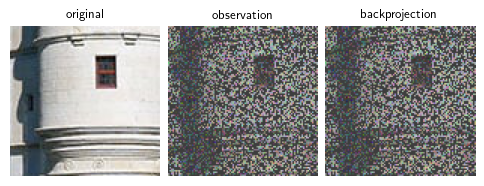

In [3]:
# Inpainting
noise_pow = 0.1
inpainting = 0.8  # proportion of pixels to keep
g = GaussianNoise(sigma=noise_pow)
physics = Inpainting(x_ref.shape[1:], mask=inpainting, noise_model=g, device=device)
y = physics(x_ref)
back = physics.A_adjoint(y)

deepinv.utils.plot([x_ref, y, back], titles=['original','observation','backprojection'])

## 4- Reconstruction: DeepInv implementation

In [45]:
lambda_tv = 2.5 * noise_pow

iters_fine = 400
iters_vec = [5, 5, 5, iters_fine]
if device == "cpu":
    iters_vec = [5, 5, iters_fine]

levels = len(iters_vec)
p_multilevel = MultiLevelParams({"iters": iters_vec})


lambda_vec = [lambda_tv / 4 ** i for i in range(0, levels)]
lambda_vec.reverse()
p_multilevel.params['lambda'] = lambda_vec

step_coeff = 0.9
stepsize_vec = [step_coeff / (l0 + 1.0) for l0 in lambda_vec]
p_multilevel.params['stepsize'] = stepsize_vec
p_multilevel.params['verbose'] = [False] * levels
p_multilevel.params['verbose'][levels - 1] = True
p_multilevel.params['gamma_moreau'] = [1.1] * levels  # smoothing parameter
p_multilevel.params['gamma_moreau'][-1] = 1.0  # fine smoothing parameter

params_tv = {
    'cit': BlackmannHarris(),
    'level': levels,
    'params_multilevel': p_multilevel,
    'iml_max_iter': 6,
    'scale_coherent_grad': True,
    'prox_crit': 1e-6,
    'prox_max_it': 1000,
}

data_fidelity = L2()
prior = TVPrior(def_crit=params_tv["prox_crit"], n_it_max=params_tv["prox_max_it"])
def F_fn(x, cur_data_fidelity, cur_prior, cur_params, y, physics):
    return cur_data_fidelity(x, y, physics) + cur_params['lambda'] * cur_prior(x)
iteration_level = PGDIteration(has_cost=True, F_fn=F_fn)
iteration = MultiLevelIteration(iteration_level)

f_init = lambda x, physics: {'est': [x], 'cost': None}
iters = params_tv['params_multilevel'].params['iters'][-1]

model = optim_builder(
    iteration=iteration,
    prior=prior,
    data_fidelity=data_fidelity,
    max_iter=iters,
    g_first=False,
    early_stop=True,
    crit_conv='residual',
    thres_conv=1e-6,
    verbose=True,
    params_algo=copy.deepcopy(params_tv),
    custom_init=f_init
)

In [47]:
x_est, met = model(y, physics, x_gt=x_ref, compute_metrics=True)

x0 = f_init(y, physics)['est'][0]
plot([x_est, x0, x_ref, y], titles=["est", "x0", "ref", "y"])
plot_curves(met)
